# Convolutional Network Implementation

In [1]:
import skimage.data as data
import numpy as np
import math

from skimage import color
from skimage.transform import resize
from matplotlib import pyplot as plt

%matplotlib inline

## Data Preprocessing

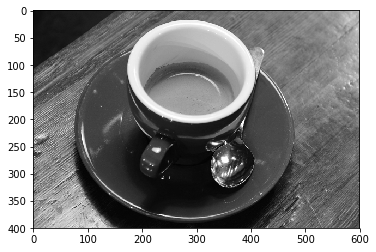

In [2]:
image = data.coffee()                 # astronaut,chelsea,coffee,camera
image = color.rgb2gray(image)

# image = resize(image,(240,320))

plt.imshow(image, cmap='gray')

In [3]:
image.shape

(400, 600)

## Feature Filters

In [4]:
conv_0_filters = np.zeros((2,3,3))

conv_0_filters[0,:,:] = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])      # Horizontal filter
conv_0_filters[1,:,:] = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])      # Vertical filter

conv_0_filters.shape

(2, 3, 3)

## Convolution Layer

In [5]:
def relu(z):
    return z * (z > 0.0)

In [6]:
def dimension(height,width,kernel_size,stride,padding):
    pad_size=0

    if padding == 'same' and kernel_size!=2:
        if stride == 1:
            pad_size = np.uint32(math.ceil((kernel_size-1)/2))
        else:
            raise Exception('padding=same works with stride=1')
        
    xdim = np.uint32(math.ceil(height+2*pad_size-kernel_size)/stride)+1
    ydim = np.uint32(math.ceil(width+2*pad_size-kernel_size)/stride)+1
    
    return (xdim,ydim,pad_size)

In [7]:
def conv2D(image,filters,stride=1,padding='valid',activation=None):
    kernel_size = filters.shape[1]
    
    height,width,_ = dimension(image.shape[0],image.shape[1],kernel_size,stride,padding)
    feature_maps = np.zeros((filters.shape[0],height,width))
    
    for i,n_filter in enumerate(filters):
        for rx,x in enumerate(range(0,image.shape[0]-kernel_size,stride)):
            for ry,y in enumerate(range(0,image.shape[1]-kernel_size,stride)):
                curr_region = image[x:(x+kernel_size),y:(y+kernel_size)]
                dot_product = curr_region * n_filter
                results = np.sum(dot_product)
                
                if activation is not None:
                    results = activation(results)
                feature_maps[i,rx,ry] = results
    return feature_maps

In [8]:
conv_0_feature_map = conv2D(image,conv_0_filters,padding='same',activation=relu)
conv_0_feature_map.shape

(2, 400, 600)

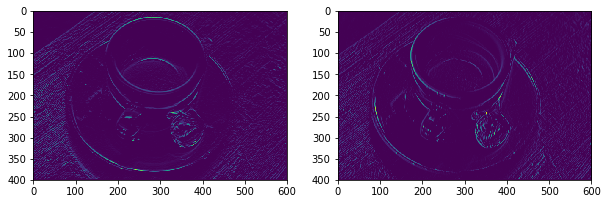

In [9]:
plt.figure(figsize=(10,10))
for i,img in enumerate(conv_0_feature_map):
    plt.subplot(1,conv_0_feature_map.shape[0],1+i)
    plt.imshow(img)

In [10]:
conv_0_feature_map.shape

(2, 400, 600)

## Max Pooling

In [11]:
def pooling2D(feature_maps,kernel_size=2,stride=2, padding='valid'):
    
    height,width,_ = dimension(feature_maps.shape[1],feature_maps.shape[2],kernel_size,stride,padding)
    poolings = np.zeros((feature_maps.shape[0],height,width))
    
    for i,feature_map in enumerate(feature_maps):
        for rx,x in enumerate(range(0,feature_map.shape[0]-kernel_size,stride)):
            for ry,y in enumerate(range(0,feature_map.shape[1]-kernel_size,stride)):
                poolings[i,rx,ry] = np.max(feature_map[x:x+kernel_size,y:y+kernel_size])
    return poolings

In [12]:
pooled_0_features = pooling2D(conv_0_feature_map,kernel_size=2,stride=2)
pooled_0_features.shape

(2, 200, 300)

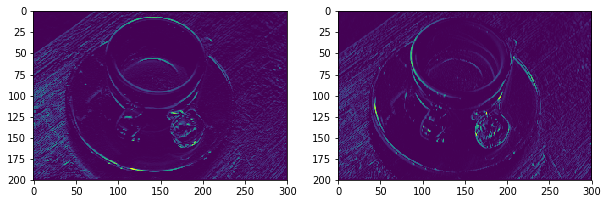

In [13]:
plt.figure(figsize=(10,10))
for i,img in enumerate(pooled_0_features):
    plt.subplot(1,pooled_0_features.shape[0],1+i)
    plt.imshow(img)

In [14]:
conv_1_filters = np.zeros((2,3,3))

conv_1_filters[0,:,:] = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
conv_1_filters[1,:,:] = np.array([[1,1,1],[0,0,0],[-1,-1,-1]])

conv_1_filters.shape

(2, 3, 3)

In [15]:
conv_1_feature_map = conv2D(pooled_0_features[1],conv_1_filters,padding='same',activation=relu)
conv_1_feature_map.shape

(2, 200, 300)

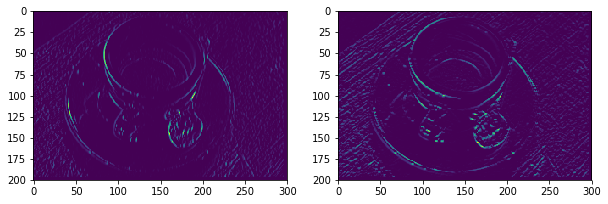

In [16]:
plt.figure(figsize=(10,10))
for i,img in enumerate(conv_1_feature_map):
    plt.subplot(1,conv_1_feature_map.shape[0],1+i)
    plt.imshow(img)

In [17]:
pooled_1_features = pooling2D(conv_1_feature_map,kernel_size=2,stride=2)
pooled_1_features.shape # n*m features to feed to the Fully Connected Neural Network

(2, 100, 150)

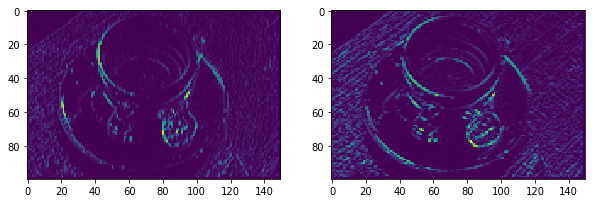

In [18]:
plt.figure(figsize=(10,10))
for i,img in enumerate(pooled_1_features):
    plt.subplot(1,pooled_1_features.shape[0],1+i)
    plt.imshow(img)